# 線形判別分析(Linear Discriminant Analysis)
２つの母集団を設定して、あるサンプルがどちらの母集団に属するのかを推測する方法。

 - 非説明変数: 質的変数
 - 説明変数: 量的変数

ex) 倒産予測モデル

 - 財務データの値$x_{1},\cdots,x_{n}$から倒産危機にあるのか否かを判別
 - 判別できるとすればその精度はどのくらいか

In [12]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from numpy.random import *

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

(array([   3.,    3.,    6.,   17.,   38.,   48.,   79.,   95.,  109.,
         136.,  121.,  113.,   84.,   51.,   46.,   27.,   14.,    6.,
           3.,    1.]),
 array([  40.0538714 ,   43.13666521,   46.21945903,   49.30225285,
          52.38504666,   55.46784048,   58.5506343 ,   61.63342812,
          64.71622193,   67.79901575,   70.88180957,   73.96460338,
          77.0473972 ,   80.13019102,   83.21298483,   86.29577865,
          89.37857247,   92.46136628,   95.5441601 ,   98.62695392,
         101.70974773]),
 <a list of 20 Patch objects>)

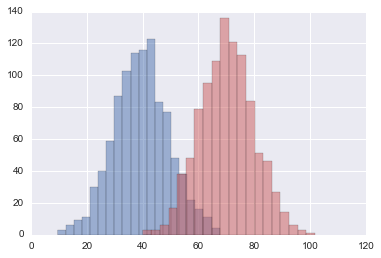

In [30]:
seed(0)

size = 1000

dataset1 = DataFrame({
        'x': normal(40,10, size),
        'y': np.array([0 for i in range(size)])
    })
dataset2 = DataFrame({
        'x': normal(70, 10, size),
        'y': np.array([1 for i in range(size)])
    })

dataset = pd.concat([dataset1, dataset2])

plt.hist(dataset[dataset.y == 0].x, alpha=0.5, bins=20)
plt.hist(dataset[dataset.y == 1].x, alpha=0.5, bins=20, color="indianred")

## 解析ストーリー

 1. 健常者を母集団[1]、患者を母集団[2]とする。母集団[1]と母集団[2]における変数の確率分布を母平均(ベクトル)が異なる正規分布と想定する。
     - 変数の値からそれぞれの母集団への距離として**マハラノビス距離**の2乗を求める
     - マハラノビス距離の2乗値の小さい母集団へ判別するという判別方式を定める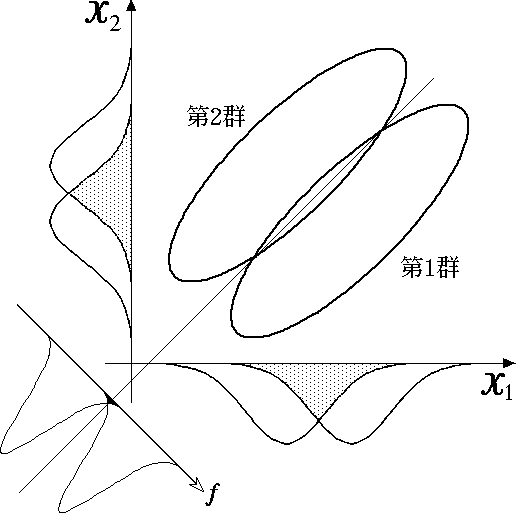
 2. **誤判別の確率**を求め、得られた判別方式の精度を評価する
 3. 変数選択を行い、有用な変数を選択する
 4. 得られた判別方式を利用して、どちらの母集団に属するのか不明なサンプルの判別を行う

---
## 1. マハラノビス距離と判別方式を求める
変数が１つだけの場合を説明する

 - 母集団[1]における$x_{1}$の確率分布: $N\left( {\mu}_{1}^{[1]}, {\sigma}^{2} \right)$
 - 母集団[2]における$x_{1}$の確率分布: $N\left( {\mu}_{1}^{[2]}, {\sigma}^{2} \right)$
(二つの母分散は同じとする)

このとき、２つの母集団のどちらかに属するが、どちらに属するのかわからないサンプルがあるとする。

### マハラノビス距離の算出
サンプルの測定値$x_{1}$からそれぞれの母集団への距離としてマハラノビス距離を求める。
$$
{D}^{[1]2} = \frac {\left( x_{1} - \mu_{1}^{[1]} \right)^{2}}{ \sigma^{2} },\quad {D}^{[2]2} = \frac {\left( x_{1} - \mu_{1}^{[1]} \right)^{2}}{ \sigma^{2} } \qquad (1)
$$

> １次元正規分布$N\left( \mu, \sigma^{2} \right)$の確率密度関数とマハラノビス距離の２乗には次のような対応関係がある。$$f\left( x \right) =\frac { 1 }{ \sqrt { 2\pi  } \sigma  } exp\left\{ -\frac { { \left( x-\mu  \right)  }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  \right\} =\frac { 1 }{ \sqrt { 2\pi  } \sigma  } exp\left\{ -\frac { { D }^{ 2 } }{ 2 }  \right\} \qquad (2)$$

マハラノビス距離を用いて判別方式を次の(3)式のように定める。
> - $D^{ [1]2 }\le D^{[2]2} \Longleftrightarrow $ 母集団[1]に属する
> - $D^{ [1]2 }\ge D^{[2]2} \Longleftrightarrow $ 母集団[2]に属する

### 判別方式の導出
式(1)より
$$
D^{ [2]2 }-D^{ [1]2 }=\frac { { x }_{ 1 }^{ 2 }-2{ \mu  }_{ 1 }^{ [2] }{ x }_{ 1 }+{ \mu  }_{ 1 }^{ [2]2 }-{ x }_{ 1 }^{ 2 }+2{ \mu  }_{ 1 }^{ [1] }{ x }_{ 1 }-{ \mu  }_{ 1 }^{ [1]2 } }{ { \sigma  }^{ 2 } } \\ \qquad \qquad \quad \quad =\frac { 2\left( { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } \right)  }{ { \sigma  }^{ 2 } } \left( { x }_{ 1 }-\frac { { \mu  }_{ 1 }^{ [1] }+{ \mu  }_{ 1 }^{ [2] } }{ 2 }  \right) \qquad (4)
$$
が成り立つ。これを2で割った
$$
z = \frac {D^{ [2]2 }-D^{ [1]2 }}{2} = \frac { \left( { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } \right)  }{ { \sigma  }^{ 2 } } \left( { x }_{ 1 }-\bar { \mu  }  \right)  \qquad (5)\\
ただし、\bar { \mu  } =\frac { { \mu  }_{ 1 }^{ [1] }+{ \mu  }_{ 1 }^{ [2] } }{ 2 }
$$

を**線形判別関数**と呼ぶ。
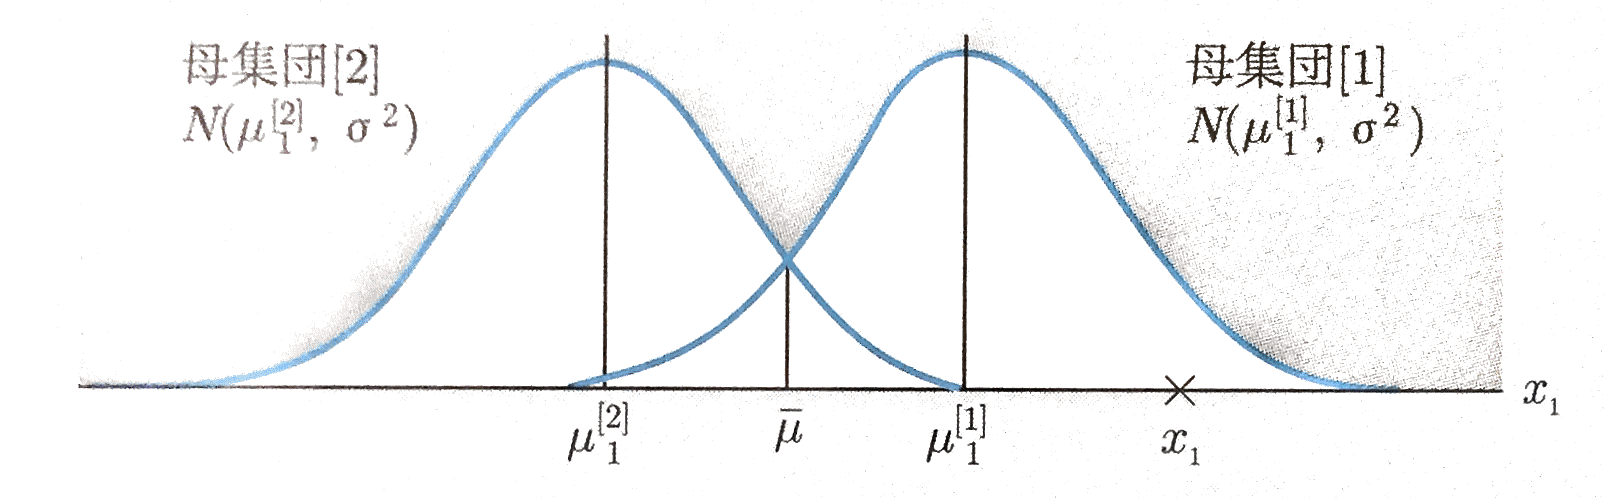

この線形判別関数を用いると(3)式の判別方式は次のようになる。
> - $z \ge 0 \Longleftrightarrow D^{ [1]2 }\le D^{[2]2} \Longleftrightarrow $ 母集団[1]に属する
> - $z < 0 \Longleftrightarrow D^{ [1]2 }\ge D^{[2]2} \Longleftrightarrow $ 母集団[2]に属する

<font color="red">通常2つの母集団の母平均、母分散は未知だから、データよりこれらを推定する</font>。個々のサンプルの変数の値を線形判別関数の推定式$\hat {z}$に代入して得られた値を**<font color="blue">スコア(判別得点)</font>**と呼ぶ。

In [35]:
# 1変数だけで判別分析を行う
from sklearn.cross_validation import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

X = dataset.x
Y = dataset.y

# 交差検証(ホールドアウト法)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, train_size=0.7, random_state=0)

clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)

print('学習データ数: %s' % x_train.shape[0])
print('学習データのうち離職した人数: %s' % y_train[y_train == 1].shape[0])
print('検証データ数: %s' % x_test.shape[0])
print('検証データのうち離職した人数: %s' % y_test[y_test == 1].shape[0])

y_pred = linear_svc.predict(x_test)

print('---モデルの評価---')
print('正確度: %s' % accuracy_score(y_test, y_pred))
print('適合率: %s' % precision_score(y_test, y_pred))
print('再現率: %s' % recall_score(y_test, y_pred))
print('F値: %s' % f1_score(y_test, y_pred))

print('---分割表---')
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['健常者', '患者'], columns=['健常者と予測', '患者と予測'])
confusion_df

TypeError: 'numpy.ndarray' object is not callable

---
# 2. 誤判別の確率と精度の評価
### 誤判別の確率を推定: 母集団[1]に属するサンプルが母集団[2]に属すると誤判別する確率
$\delta ={ \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] }>0$を仮定する(逆向きでも同様の結果を得る)
$x_{ 1 }\sim N\left( { \mu  }_{ 1 }^{ [1] },{ \sigma  }^{ 2 } \right)$→$z$の表現$z\sim N\left( E\left( z \right) ,V\left( z \right)  \right) $にする。まず、期待値・分散を導出するために線形判別関数を簡単にする。
$$
z=\frac { { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } }{ { \sigma  }^{ 2 } } { x }_{ 1 }-\frac { \left( { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } \right) \left( { \mu  }_{ 1 }^{ [1] }+{ \mu  }_{ 1 }^{ [2] } \right)  }{ 2{ \sigma  }^{ 2 } } 
$$
期待値は、
$$
E\left( z \right) =\frac { { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } }{ { \sigma  }^{ 2 } } E\left( { x }_{ 1 } \right) -\frac { \left( { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } \right) \left( { \mu  }_{ 1 }^{ [1] }+{ \mu  }_{ 1 }^{ [2] } \right)  }{ 2{ \sigma  }^{ 2 } } \\ \quad \quad \quad =\frac { { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } }{ { \sigma  }^{ 2 } } { \mu  }_{ 1 }^{ [1] }-\frac { \left( { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } \right) \left( { \mu  }_{ 1 }^{ [1] }+{ \mu  }_{ 1 }^{ [2] } \right)  }{ 2{ \sigma  }^{ 2 } } \\ \qquad =\frac { { \delta  }^{ 2 } }{ 2{ \sigma  }^{ 2 } } 
$$
となる。分散は、
$$
V\left( z \right) ={ \left[ \frac { { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } }{ { \sigma  }^{ 2 } }  \right]  }^{ 2 }V\left( { x }_{ 1 } \right)=\frac { { \left( { \mu  }_{ 1 }^{ [1] }-{ \mu  }_{ 1 }^{ [2] } \right)  }^{ 2 } }{ { \sigma  }^{ 4 } } { \sigma  }^{ 2 } =\frac { { \delta  }^{ 2 } }{ { \sigma  }^{ 2 } } 
$$
となる。この分散の計算には、1次式$y=ax+b$によって１次変換された値$y$の分散$V\left(y\right)$は$a^{2}V\left(x\right)$を用いている。

上式より、$z\sim N\left( { \delta ^{ 2 } }/{ (2{ \sigma  }^{ 2 }) },{ \delta ^{ 2 } }/{ { \sigma  }^{ 2 } } \right) $となる。これより、

 - 母集団[1]に所属するサンプルが母集団[2]に属すると誤判別される確率は、次式となる
$$
Pr\left( z<0 \right) = Pr\left( \frac { z-\cfrac { \delta ^{ 2 } }{ 2{ \sigma  }^{ 2 } }  }{ \cfrac { \delta  }{ \sigma  }  } <\frac { 0-\cfrac { \delta ^{ 2 } }{ 2{ \sigma  }^{ 2 } }  }{ \cfrac { \delta  }{ \sigma  }  }  \right) =Pr\left( u<-\cfrac { \delta  }{ 2\sigma  }  \right) =Pr\left( u>\cfrac { \delta  }{ 2\sigma  }  \right) \qquad (7)
$$
ただし、$u \sim N\left(0, 1\right)$である。また、

 - 母集団[2]に属するサンプルなのに、母集団[1]に属すると誤判別する確率は次式を求める。$x_{ 1 }\sim N\left( { \mu  }_{ 1 }^{ [2] },{ \sigma  }^{ 2 } \right)$の下で、$z\sim N\left( -{ \delta ^{ 2 } }/{ (2{ \sigma  }^{ 2 }) },{ \delta ^{ 2 } }/{ { \sigma  }^{ 2 } } \right) $となることより、
$$
Pr\left( z\ge 0 \right) =Pr\left( \frac { z+\cfrac { \delta ^{ 2 } }{ 2{ \sigma  }^{ 2 } }  }{ \cfrac { \delta  }{ \sigma  }  } \ge \frac { 0+\cfrac { \delta ^{ 2 } }{ 2{ \sigma  }^{ 2 } }  }{ \cfrac { \delta  }{ \sigma  }  }  \right) =Pr\left( u\ge \cfrac { \delta  }{ 2\sigma  }  \right) \qquad (8)
$$
となる。

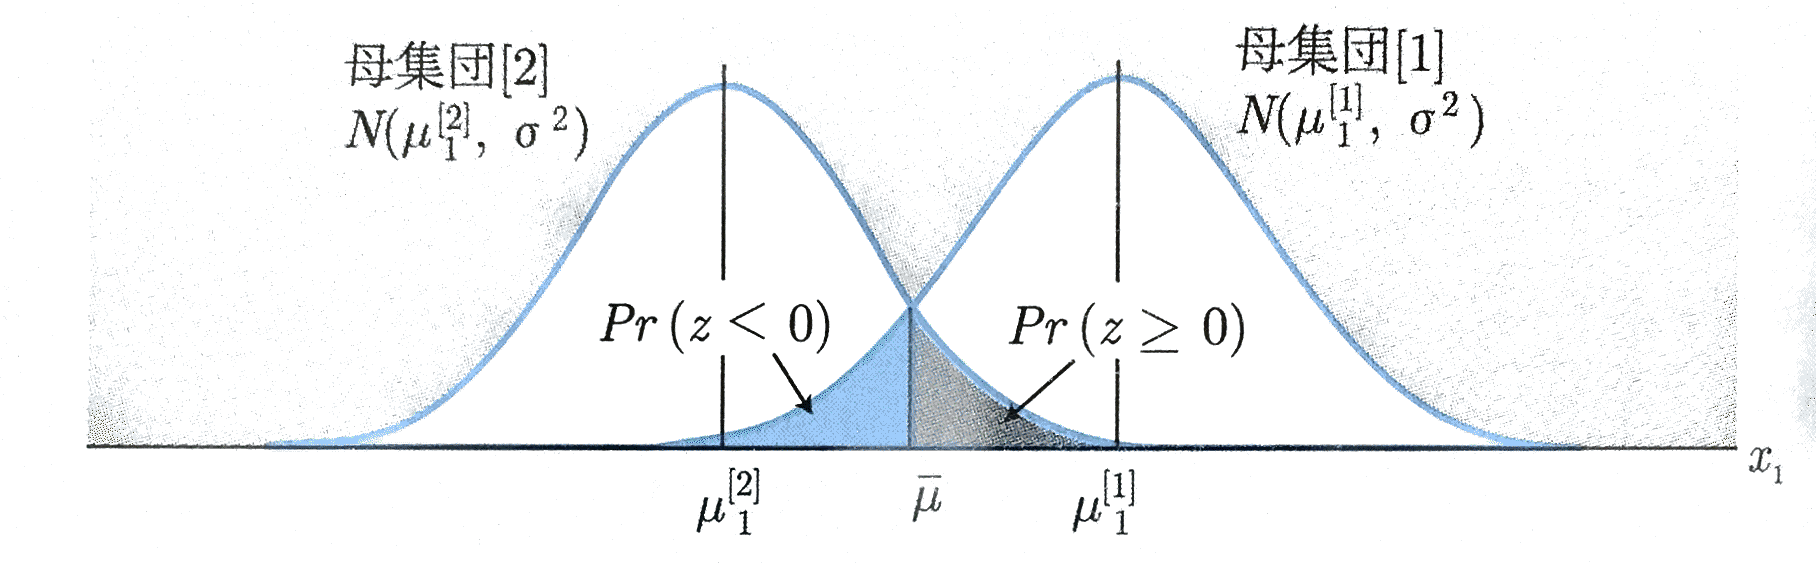

### 判別精度の評価

| データ結果 | 健常者 | 患者 | 計 |
|:------------:|:--------:|:-----:|:---:|
| 健常者 |  |  |  |
| 患者 |  |  |  |
| 計 |  |  |  |

式(7)や式(8)からわかるように、$\mu_{1}^{[1]}$と$\mu_{1}^{[2]}$の差が大きいほど誤判別の確率は小さくなり、判別はより正確になる。そこで、母集団間の距離として2つの母平均のマハラノビス距離の2乗を定義する。これを**<font color="blue">判別効率</font>**と呼ぶ。
$$
D_{x_{1}}^{2}\left([1],[2]\right) = \frac {\left( \mu_{1}^{[1]} - \mu_{1}^{[2]} \right)^{2}}{\sigma^{2}} \qquad (9)
$$